In [10]:
import omnipath as op
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pySankey import sankey as sn
import mellon as ml
import networkx as nx
from matplotlib.pyplot import figure

c:\Users\melis\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
db = op.interactions.import_intercell_network(transmitter_params = {"categories":"ligand"}, receiver_params = {"categories": "receptor"})
db = db[np.logical_not(db['genesymbol_intercell_source'].str.startswith('HLA'))]
tgts_all = pd.read_csv('/Users/melis/Documents/Gene-targets/Disease_gene_associations_OpenTargets/hot-encoded-diseases.csv')
tgts_all['gene']=tgts_all['genes']
tgts = tgts_all.drop(columns=['genes']).set_index(['gene'])


In [12]:
source, percSrc, targets, percTgt, sum = ml.lr.find_hits(tgts, db)

Source hits:  111
% of source hits in total genes of interest:  4.431137724550898
Target hits:  266
% of target hits in total genes of interest:  10.6187624750499


In [14]:
LRs = db[['genesymbol_intercell_source','genesymbol_intercell_target']][(db['genesymbol_intercell_source'].isin(list(sum.gene))) | (db['genesymbol_intercell_target'].isin(list(sum.gene)))]

unique_genes = np.unique(list(LRs['genesymbol_intercell_source'])+list(LRs['genesymbol_intercell_target']))

# Adjacency matrix with entire network linked to targets of interest
# This should include only LRs_SCZ interactions (where at least one of the interactors is linked to SCZ)
adj_LRs = pd.DataFrame(np.zeros(shape=(len(unique_genes), len(unique_genes))), index = unique_genes, columns = unique_genes)

for n in range (0, np.shape(LRs)[0]):
    adj_LRs.iloc[adj_LRs.index.get_loc(LRs.iloc[n]['genesymbol_intercell_source']), adj_LRs.columns.get_loc(LRs.iloc[n]['genesymbol_intercell_target'])] += 1

#Number of cell-cell interactions ligands of interest are involved in
print(adj_LRs.sum(axis = 0).sort_values(ascending=False)[adj_LRs.sum(axis = 0).sort_values(ascending=False).index.isin(list(tgts.index))])

#Number of cell-cell interactions receptors of interest are involved in
adj_LRs.sum(axis = 1).sort_values(ascending=False)[adj_LRs.sum(axis = 1).sort_values(ascending=False).index.isin(list(tgts.index))]

MAPK3    82.0
MAPK1    75.0
STAT3    66.0
CXCR4    51.0
CCR4     46.0
         ... 
IMPG2     0.0
IFNK      0.0
IL12A     0.0
IL12B     0.0
ZPBP2     0.0
Length: 353, dtype: float64


FYN       157.0
TGFB1     103.0
IL2        65.0
HGF        57.0
TYK2       42.0
          ...  
LPP         0.0
LRP1        0.0
LRRC4C      0.0
LRRN3       0.0
AATK        0.0
Length: 353, dtype: float64

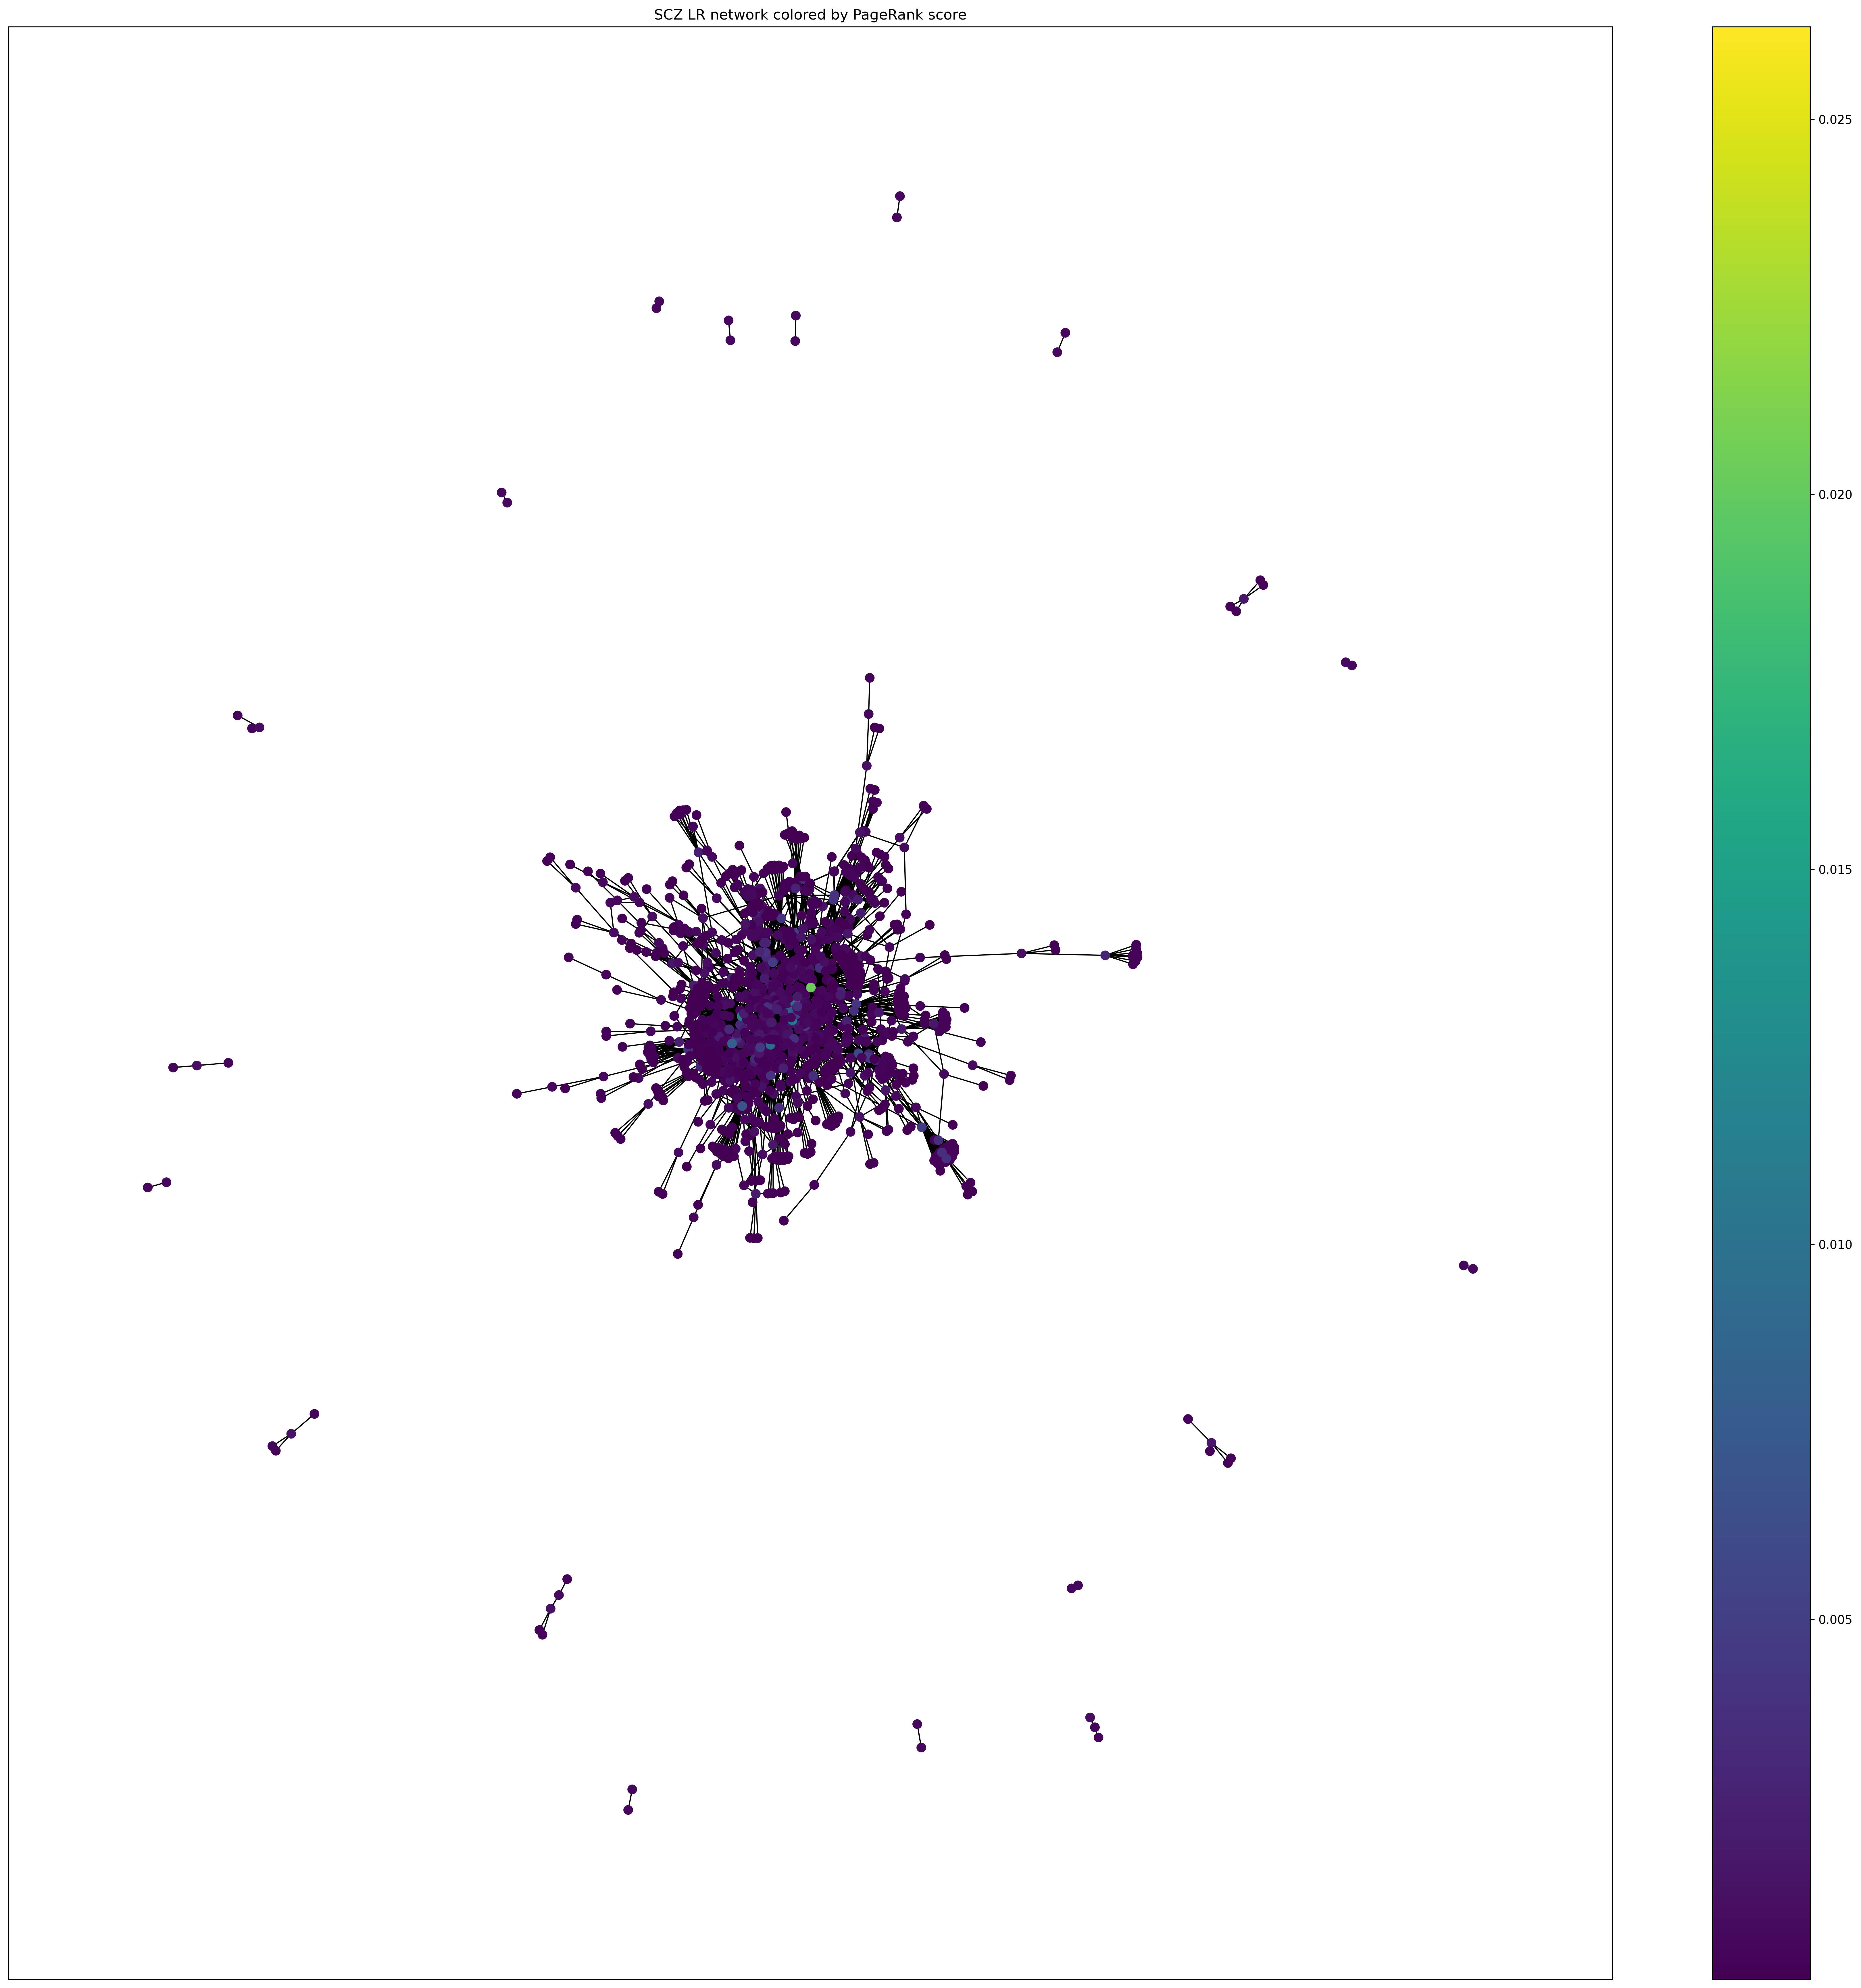

In [22]:
# Overview of LR network and calculating rank of importance with PageRank

G = nx.from_pandas_adjacency(adj_LRs)
pgrank = pd.DataFrame.from_dict(nx.pagerank(G, alpha = 0.85, weight = 'weight'), orient = 'index')
pgrank.sort_values(by=[0], ascending = False).to_csv('processed_data/pagerank_outputs.csv')

colours = []
for i in G.nodes:
        if i in list(pgrank.index):
            colours.append(pgrank.loc[i][0])
        else:
            colours.append(0.0)
len(colours)

plt.figure(figsize=(30,30), dpi = 300)

sm = nx.draw_networkx(G, node_color=colours, vmin=min(colours), vmax=max(colours), cmap=plt.get_cmap("viridis"), with_labels=False, node_size = 50)
sm = plt.cm.ScalarMappable(cmap=plt.get_cmap("viridis"), norm=plt.Normalize(vmin = min(colours), vmax=max(colours)))
sm._A = []
plt.colorbar(sm)
plt.title('plots/SCZ LR network colored by PageRank score')
plt.show()

In [24]:
df = pd.read_csv('/Users/melis/Documents/Gene-targets/Disease_gene_associations_OpenTargets/risk-score-all-diseases.csv', index_col = 0)
sum_risk = df.sum(axis = 1).sort_values(ascending = False)

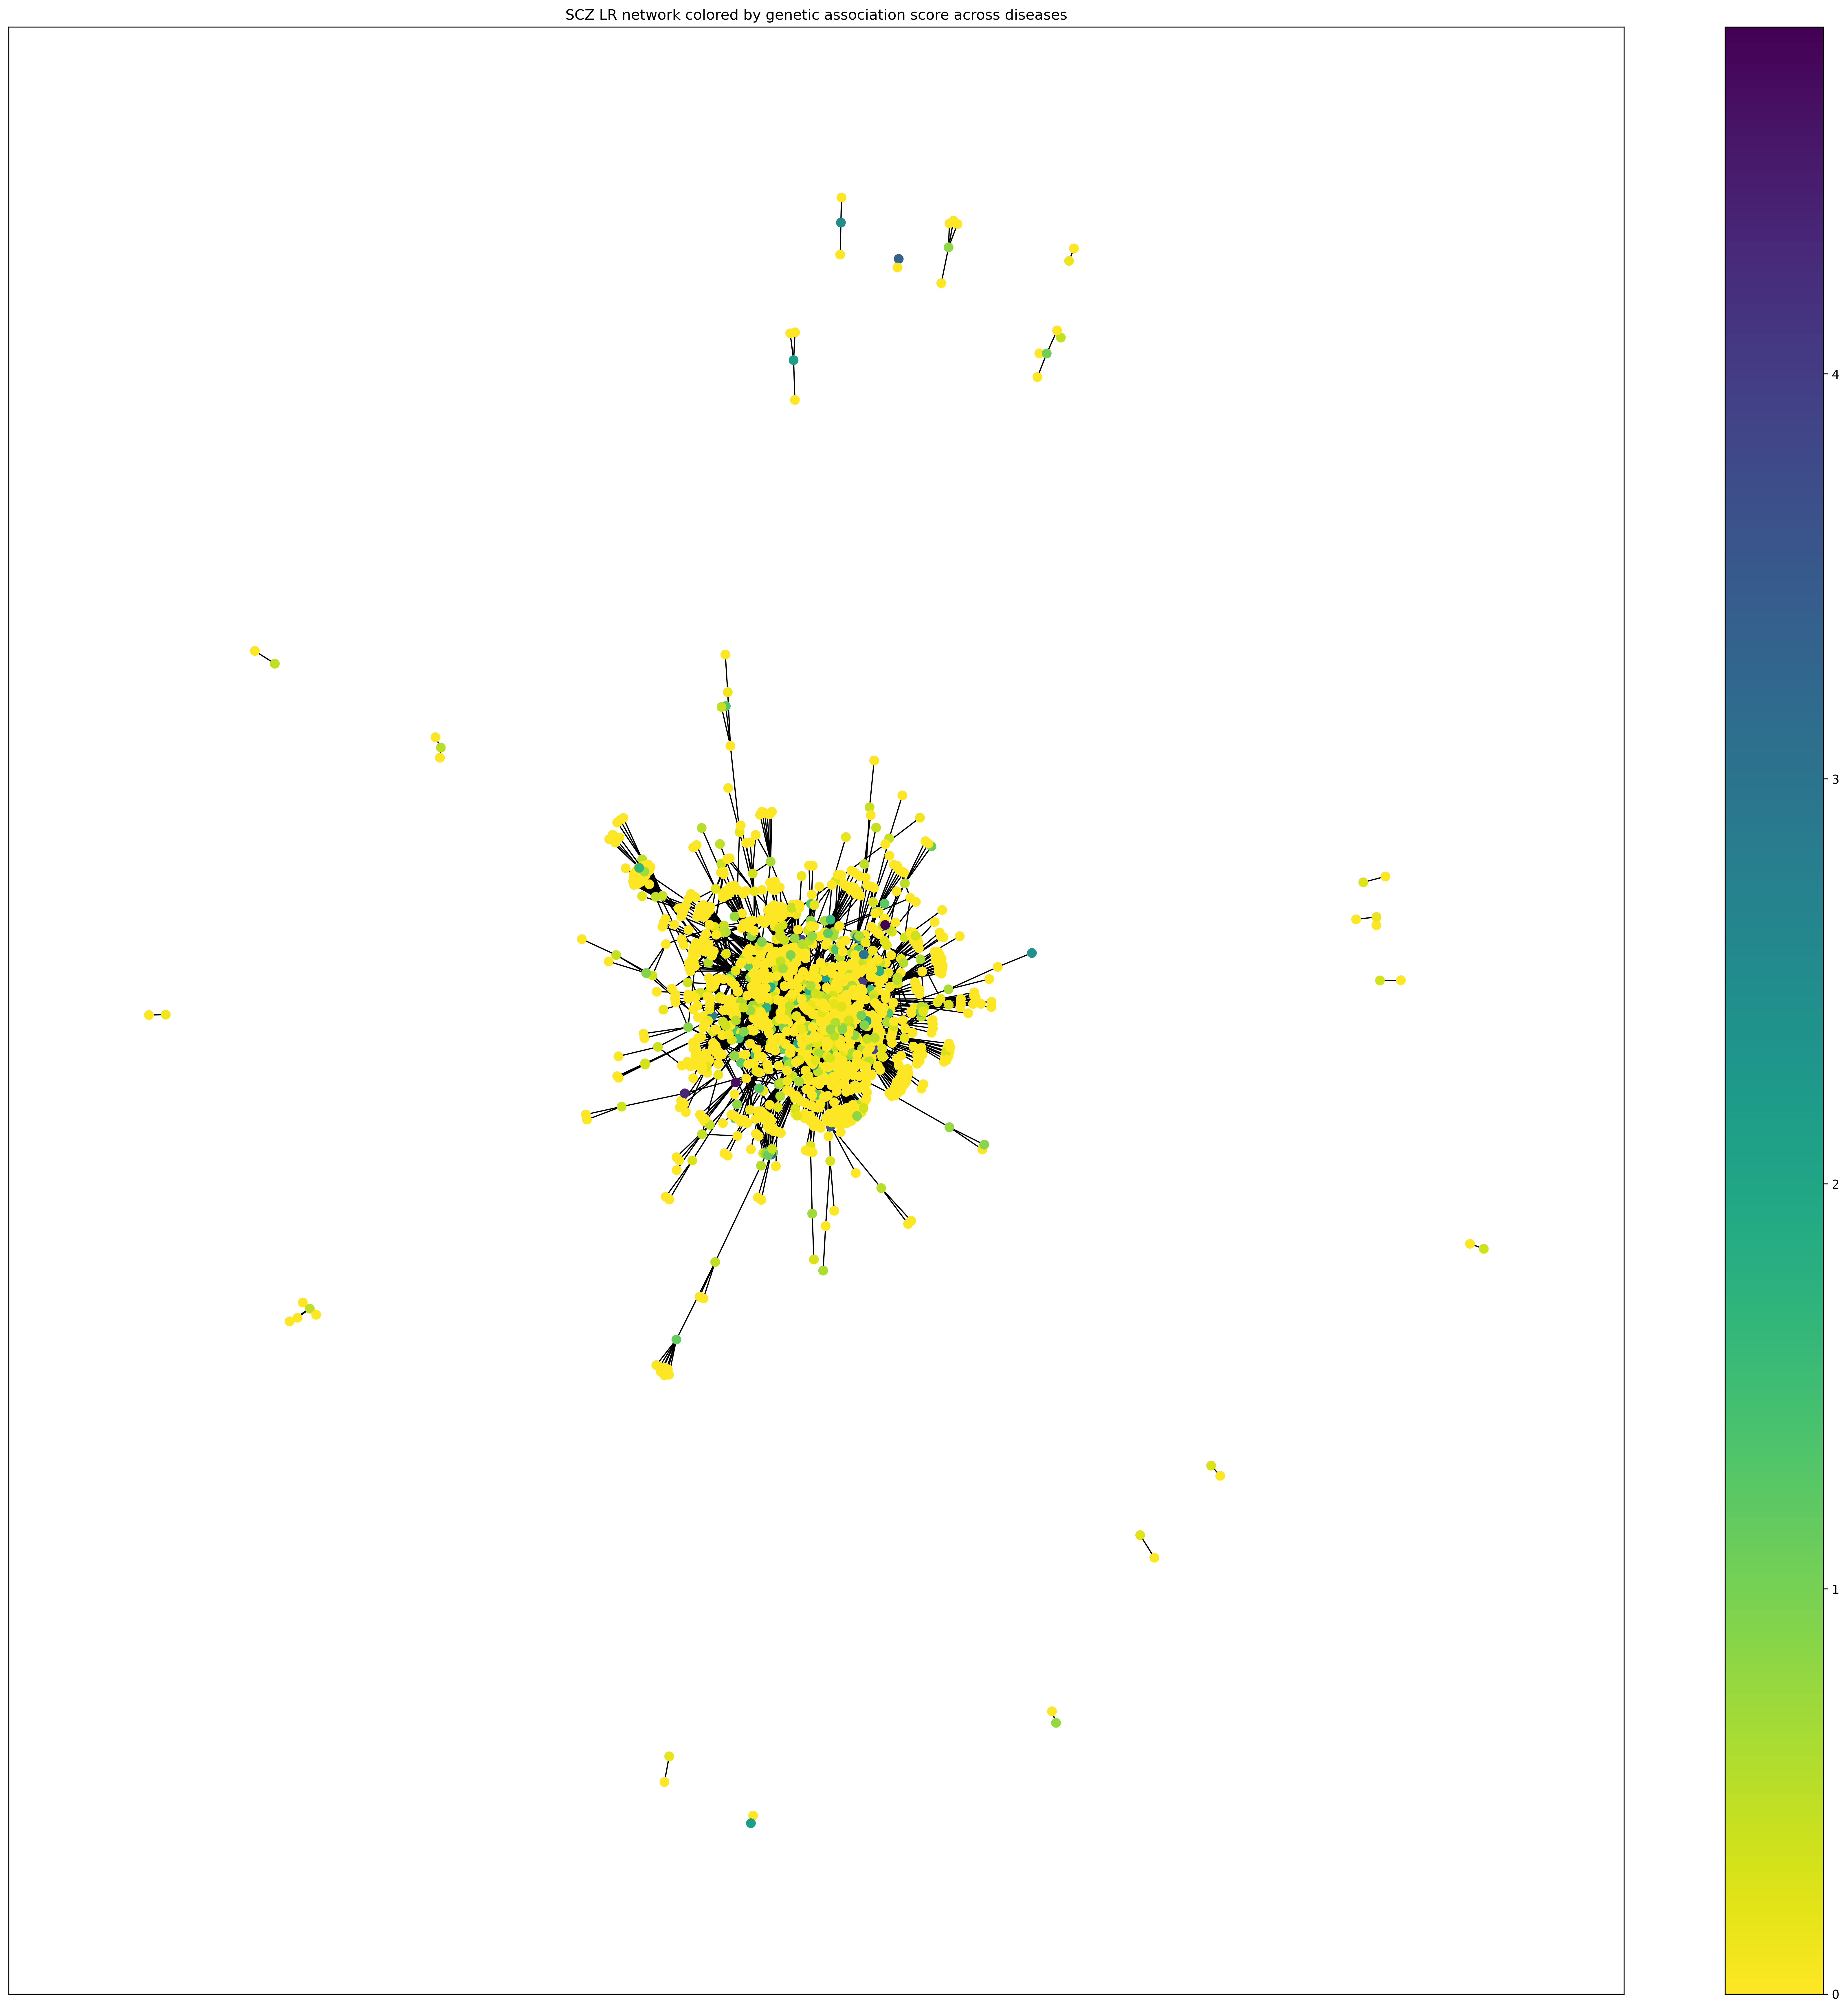

In [55]:
# Overview of LR network and calculating rank of importance with PageRank
G = nx.from_pandas_adjacency(adj_LRs)

colours = []
for i in G.nodes:
        if i in list(sum_risk.index):
            colours.append(sum_risk.loc[i])
        else:
            colours.append(0.0)
len(colours)

plt.figure(figsize=(30,30), dpi = 300)

sm = nx.draw_networkx(G, node_color=colours, vmin=min(colours), vmax=max(colours), cmap=plt.get_cmap("viridis_r"), with_labels=False, node_size = 50)
sm = plt.cm.ScalarMappable(cmap=plt.get_cmap("viridis_r"), norm=plt.Normalize(vmin = min(colours), vmax=max(colours)))
sm._A = []
plt.colorbar(sm)
plt.title('SCZ LR network colored by genetic association score across diseases')
plt.show()